In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import datetime
import json
import os
import sys
import time
from urllib.request import urlopen
import xarray as xr


In [2]:


# Number of attempts to download data
MAX_ATTEMPTS = 6
# HTTPS here can be problematic for installs that don't have Lets Encrypt CA
SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"


def download_data(uri):
    """Fetch the data from the IEM

    The IEM download service has some protections in place to keep the number
    of inbound requests in check.  This function implements an exponential
    backoff to keep individual downloads from erroring.

    Args:
      uri (string): URL to fetch

    Returns:
      string data
    """
    attempt = 0
    while attempt < MAX_ATTEMPTS:
        try:
            data = urlopen(uri, timeout=300).read().decode("utf-8")
            if data is not None and not data.startswith("ERROR"):
                return data
        except Exception as exp:
            print(f"download_data({uri}) failed with {exp}")
            time.sleep(5)
        attempt += 1

    print("Exhausted attempts to download, returning empty data")
    return ""


In [3]:
asos_station_df = pd.read_csv('../data/geodata/iem_stations_co_asos.csv',)
asos_station_gdf = gpd.GeoDataFrame(asos_station_df, geometry=gpd.points_from_xy(asos_station_df['lon'], asos_station_df['lat'], asos_station_df['elev']), crs='EPSG:4326')
# if endts is not nan, then drop the station
asos_station_gdf = asos_station_gdf[asos_station_gdf['endts'].isna()]
# drop stations with start dates after 2010
asos_station_gdf['begints'] = pd.to_datetime(asos_station_gdf['begints'])
asos_station_gdf = asos_station_gdf[asos_station_gdf['begints'] < dt.datetime(1980,10,1)]
# pull in ucrb boundary
ucrb_boundary = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')
# clip the asos stations to the ucrb boundary
ucrb_asos_stations = gpd.clip(asos_station_gdf, ucrb_boundary).reset_index(drop=True)
asos_ids = list(ucrb_asos_stations['stid'].values)
# convert ucrb_asos_stations crs to 32613
ucrb_asos_stations = ucrb_asos_stations.to_crs('EPSG:32613')

In [4]:

"""Our main method"""
# timestamps in UTC to request data for
startts = datetime.datetime(1964, 10, 1)
endts = datetime.datetime(2022, 9, 30)

service = SERVICE + "data=skyc1&data=skyc2&data=skyc3&tz=Etc/UTC&format=comma&latlon=yes&"

service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
service += endts.strftime("year2=%Y&month2=%m&day2=%d&")

# Two examples of how to specify a list of stations
stations = asos_ids
for station in stations:
    final_file = f'../data/etdata/clouds/MAM_spring/{station}_spring_avg_cc.csv'
    uri = f"{service}&station={station}"

    outfn = f"{station}_{startts:%Y%m%d%H%M}_{endts:%Y%m%d%H%M}.txt"
    if not os.path.isfile(final_file):
        print(f"Writing data to getting file ")
        if not os.path.isfile(outfn):
            print(f"Downloading: {station}")
            data = download_data(uri)
            with open(outfn, "w", encoding="ascii") as fh:
                fh.write(data)
            print(f"Data written to {outfn}")
        
        df = pd.read_csv(f'./{station}_196410010000_202209300000.txt',delimiter=',', comment='#')
        # for sky1, sky2, sky3, replace 'M' with np.nan
        # we'll say CLR, FEW, or BKN are 0 and OVC, SCT, and VV are 1 replace blanks with np.nan
        for col in ['skyc1', 'skyc2', 'skyc3']:
            df[col] = df[col].replace('M', np.nan)
            df[col] = df[col].replace('M', np.nan)
            df[col] = df[col].replace('M', np.nan)
            df[col] = df[col].replace('CLR', 0)
            df[col] = df[col].replace('FEW', 0)
            df[col] = df[col].replace('BKN', 0)
            df[col] = df[col].replace('OVC', 1)
            df[col] = df[col].replace('SCT', 1)
            df[col] = df[col].replace('VV ', 1)
            df[col] = df[col].replace('   ', np.nan)
            df[col] = df[col].replace('///', np.nan)
        df['valid'] = pd.to_datetime(df['valid'])
        # for each sky level, sum up the number of observations for each condition for each day
        test = df.groupby([df['valid'].dt.date]).agg({'skyc1': ['sum'], 'skyc2': ['sum'], 'skyc3': ['sum']})
        test.index = pd.to_datetime(test.index)
        # divide test by the number of observations for each day to estimate where >50% of the sky is covered by clouds
        value_counts = df.groupby([df['valid'].dt.date]).agg({'skyc1': ['count'], 'skyc2': ['count'], 'skyc3': ['count']})
        # if value count is 0, replace with np.nan
        value_counts = value_counts.replace(0, np.nan)
        # if value count is less than 24, replace with np.nan
        value_counts = value_counts.where(value_counts > 24)
        value_counts.index = pd.to_datetime(value_counts.index)
        avg_daily_cc1 = test['skyc1']['sum']/value_counts['skyc1']['count']
        avg_daily_cc2 = test['skyc2']['sum']/value_counts['skyc2']['count']
        avg_daily_cc3 = test['skyc3']['sum']/value_counts['skyc3']['count']

        # get average cloud cover summed over every month
        monthly_avg_cc1 = avg_daily_cc1.resample('M').mean()
        monthly_avg_cc2 = avg_daily_cc2.resample('M').mean()
        monthly_avg_cc3 = avg_daily_cc3.resample('M').mean()
        # get the average cloud cover for springs for each year
        spring_avg_cc1 = avg_daily_cc1.where(avg_daily_cc1.index.month.isin([3,4,5])).resample('Y').mean()
        # reset index to just be the year
        spring_avg_cc1.index = spring_avg_cc1.index.year
        spring_avg_cc2 = avg_daily_cc2.where(avg_daily_cc2.index.month.isin([3,4,5])).resample('Y').mean()
        spring_avg_cc2.index = spring_avg_cc2.index.year
        spring_avg_cc3 = avg_daily_cc3.where(avg_daily_cc3.index.month.isin([3,4,5])).resample('Y').mean()
        spring_avg_cc3.index = spring_avg_cc3.index.year
        # combine these into a single dataframe
        spring_avg_cc = pd.concat([spring_avg_cc1, spring_avg_cc2, spring_avg_cc3], axis=1)
        spring_avg_cc.columns = ['skyc1', 'skyc2', 'skyc3']
        # drop the highest value for the sky1 column
        spring_avg_cc = spring_avg_cc.drop(spring_avg_cc.idxmax())
        # add a column with the station
        spring_avg_cc['station'] = station
        # save the spring_avg_cc to a csv
        spring_avg_cc.to_csv(final_file)
        # remove the downloaded file
        os.remove(outfn)
    else:
        print(f"Data already downloaded for {station}")
                

Data already downloaded for DRO
Data already downloaded for CEZ
Data already downloaded for CPW
Data already downloaded for MTJ
Data already downloaded for GUC
Data already downloaded for GJT
Data already downloaded for ASE
Data already downloaded for EGE
Data already downloaded for EEO
Data already downloaded for HDN
Data already downloaded for CAG


In [5]:
# pull is prism preciptiation data
import xarray as xr
ppt_prism = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')
ppt_prism = ppt_prism.rename({'__xarray_dataarray_variable__': 'ppt'})


,ppt,skyc1
1895,52.001999,NaN
1896,33.125000,NaN
1897,104.040001,NaN
1898,81.272995,NaN
1899,39.823002,NaN
...,...,...
2018,97.470001,0.197660
2019,148.451996,0.269553
2020,103.589996,0.220046
2021,73.024902,0.180167


Station: CEZ, slope: 0.05174769947465289
Station: CPW, slope: 0.06494265122710065
Station: MTJ, slope: 0.06287049450576916
Station: GUC, slope: 0.07334810514580872
Station: GJT, slope: 0.09686205485474549
Station: ASE, slope: 0.03663214924199922
Station: EGE, slope: 0.08655649941546407
Station: EEO, slope: 0.03092846560886053
Station: HDN, slope: 0.05712528315102272
Station: CAG, slope: 0.06433779759838336


Text(0, 0.5, 'ASOS Station Cloud Cover (%)')

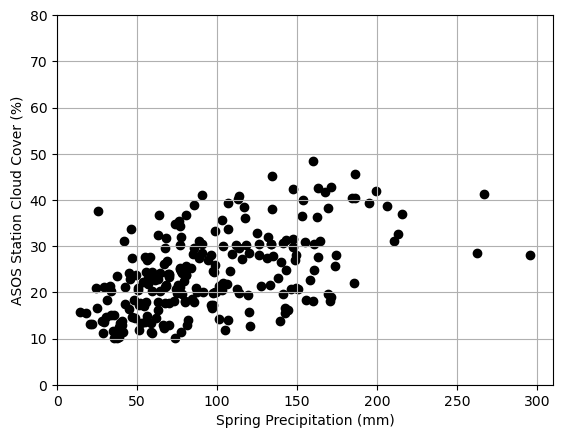

In [28]:
# rename __xarray_dataarray_variable__ to ppt
import scipy.stats as stats
# create an empty series to store values
ucrb_asos_ppt_cc = []
for station in asos_ids:
    if station in ['DRO']:
        continue
    else:
        spring_avg_cc = pd.read_csv(f'../data/etdata/clouds/MAM_spring/{station}_spring_avg_cc.csv', index_col=0)
        # nan values above 0.5
        spring_avg_cc['skyc1'] = spring_avg_cc['skyc1'].where(spring_avg_cc['skyc1'] < 0.5, np.nan)
        sta = ucrb_asos_stations[ucrb_asos_stations.stid==station].geometry.values[0]
        station_ppt = ppt_prism.sel(x=sta.x, y=sta.y, method='nearest')
        # get the spring ppt for each year
        station_ppt_spring = station_ppt.where(station_ppt.month.dt.month.isin([3,4,5])).resample(month='Y').sum()
        station_ppt_spring = station_ppt_spring.to_dataframe()['ppt']
        # reset index to just be the year
        station_ppt_spring.index = station_ppt_spring.index.year
        # add correlation to the gdf for the station
        ucrb_asos_stations.loc[ucrb_asos_stations.stid==station, 'ppt_correlation'] = station_ppt_spring.corr(spring_avg_cc['skyc1'])
        # frop sky1 values below 0.1
        spring_avg_cc = spring_avg_cc.where(spring_avg_cc['skyc1'] > 0.1, np.nan)
        # combine the ppt and cloud cover data
        ucrb_asos_ppt_cc.append(pd.concat([station_ppt_spring, spring_avg_cc['skyc1']], axis=1))
        # calculate r2 values between ppt and cloud cover
        # print the slope and intercept
        slope, intercept, r_value, p_value, std_err = stats.linregress(station_ppt_spring.loc[spring_avg_cc['skyc1'].dropna().index], spring_avg_cc['skyc1'].dropna()*100)
        print(f"Station: {station}, slope: {slope}")
        plt.scatter(station_ppt_spring.loc[spring_avg_cc['skyc1'].dropna().index], spring_avg_cc['skyc1'].dropna()*100 , color='black')
plt.grid()
plt.ylim(0,80)
plt.xlabel('Spring Precipitation (mm)')
plt.ylabel('ASOS Station Cloud Cover (%)')
    # plt.scatter(station_ppt_spring.loc[spring_avg_cc.index], spring_avg_cc['skyc1'])

Text(0.5, 1.0, 'ASOS Station Cloud Cover vs. Spring Precipitation')

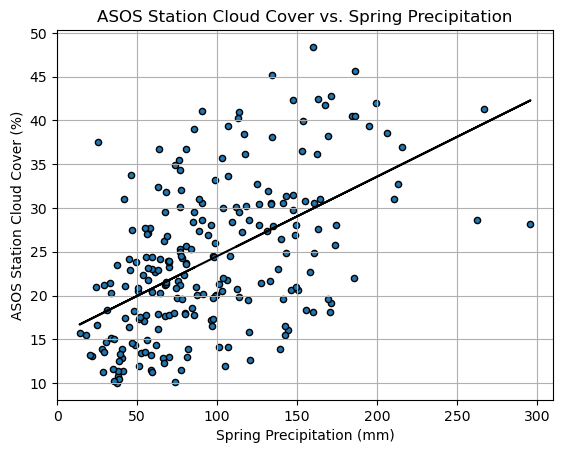

In [44]:
df = pd.concat(ucrb_asos_ppt_cc).dropna()
# multiply cloud cover by 100
df['skyc1'] = df['skyc1']*100
df.columns = ['ppt', 'cloud_cover']
fig, ax = plt.subplots()
df.plot.scatter(x='ppt', y='cloud_cover', ax=ax, ec='k')
# add a trend line
slope, intercept, r_value, p_value, std_err = stats.linregress(df['ppt'], df['cloud_cover'])
ax.plot(df['ppt'], slope*df['ppt']+intercept, color='black')
ax.grid()
ax.set_xlabel('Spring Precipitation (mm)')
ax.set_ylabel('ASOS Station Cloud Cover (%)')
ax.set_title(f'ASOS Station Cloud Cover vs. Spring Precipitation')

Text(0.5, 1.0, 'Correlation between Spring Cloud Cover from ASOS stations\nand Spring Precipitation from PRISM')

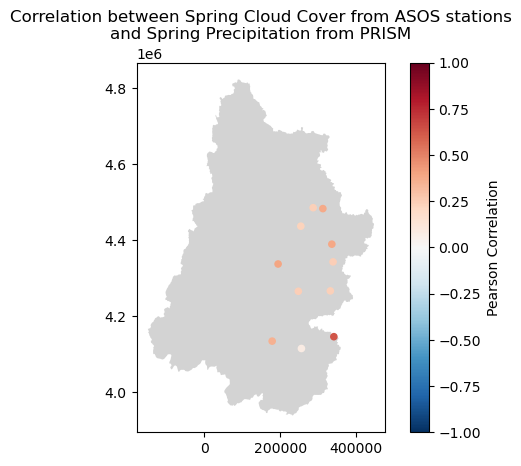

In [25]:
# plot station locations over the ucrb boundary
fig, ax = plt.subplots()
ucrb_boundary.to_crs(32613).plot(ax=ax, color='lightgrey')
# plot stations and color by correlation
ucrb_asos_stations.plot(ax=ax, 
                        column='ppt_correlation', 
                        cmap='RdBu_r', 
                        legend=True, 
                        markersize=20, 
                        vmin=-1, 
                        vmax=1,
                        legend_kwds={'label': "Pearson Correlation", 'orientation': "vertical"})
plt.title('Correlation between Spring Cloud Cover from ASOS stations\nand Spring Precipitation from PRISM')
# plt.show()